In [ ]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint , EarlyStopping
from keras.models import load_model
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import FileLink

In [2]:
x = []
y = []
img_size = (150 , 150)

In [3]:
path = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/"

In [4]:
#store all Parasited and Uninfected cell images in X and labels in Y, 0 -> Uninfected 1 -> Parasited
val = 1
curr_path = os.path.join(path , "Parasitized")
for i in os.listdir(curr_path):
    img_path = os.path.join(curr_path , i)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img , img_size)
        x.append(img)
        y.append(val)
        
val = 0
curr_path = os.path.join(path , "Uninfected")
for i in os.listdir(curr_path):
    img_path = os.path.join(curr_path , i)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img , img_size)
        x.append(img)
        y.append(val)

In [5]:
#Shuffle all images to get better training results
x , y = shuffle(x , y , random_state = 101)

In [6]:
#Cconvert x and y to numpy array to make them compatabel for model input
x = np.array(x)
y = np.array(y)

In [7]:
#Spit dataset for training and validation 80% for training and 20% for validation
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.2)

In [8]:
#build a model 
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid") #Sigmoid for binary image classification
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [10]:
#Create call backs to save best model and to save time
checkpoint_path = "/kaggle/working/best_model.h5"

mc = ModelCheckpoint(filepath= checkpoint_path,
                     monitor="val_accuracy",
                     verbose= 1,
                     save_best_only= True )

es = EarlyStopping(monitor= "accuracy",
                   min_delta= 0.01,
                   patience= 5,
                   verbose= 1)

cb = [mc,es]

In [11]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(x_train, y_train, epochs = 50, validation_data = (x_test , y_test),callbacks = cb)

In [15]:
#download the model for backup
FileLink(r'best_model.h5')

/kaggle/working/best_model.h5

In [16]:
#Load model
model = load_model('/kaggle/input/model1/best_model.h5')

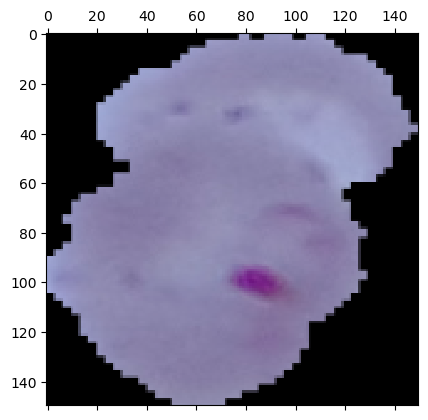

(150, 150, 3)

In [38]:
#load a image to check the prediction
test_img = cv2.imread('/kaggle/input/malaria-detection-dataset/Dataset/Test/Parasite/C39P4thinF_original_IMG_20150622_105554_cell_16.png')
test_img = cv2.resize(test_img , img_size)
plt.matshow(test_img)
plt.show()
test_img.shape

In [39]:
test_ia = np.array(test_img)
test_ia = test_ia.reshape((1, 150, 150, 3))


In [40]:
#Run inferance
if model.predict(test_ia)[0][0] > 0.5:
    print("Infected")
else:
    print("Uninfected")

1/1 [==============================] - 0s 34ms/step
Infected


In [41]:
#Function that helps to generate heatmap
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('conv2d_2') #last convolution layer in model 
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(test_ia)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
 
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

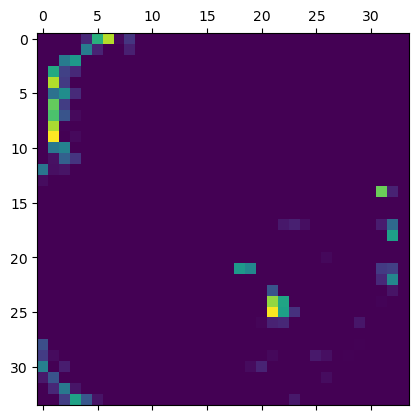

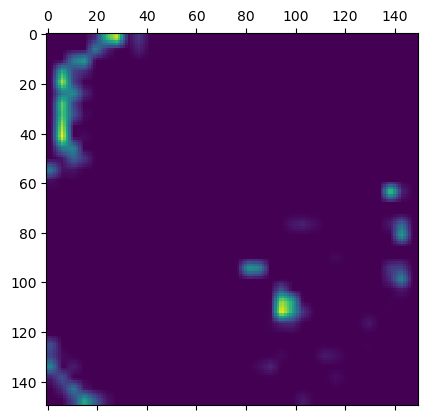

In [42]:
#Visulaize the heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((34, 34))
plt.matshow(heatmap)
plt.show()
heatmap_plt = cv2.resize(heatmap , img_size)
plt.matshow(heatmap_plt)
plt.show()

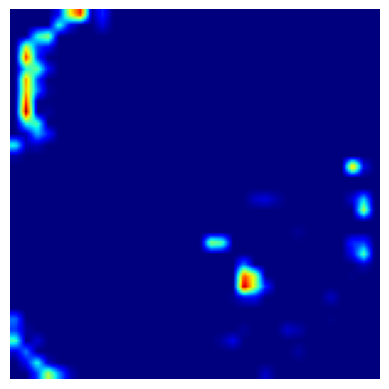

In [43]:
# Apply a color mapping schemeto convert the heat map to RGB
heatmap_rgb = plt.get_cmap('jet')(heatmap_plt)[:, :, :3]  # Keep only RGB channels viridis

# Display RGB heatmap image
plt.imshow(heatmap_rgb)
plt.axis('off')
plt.show()

In [44]:
# Resize the overlay image to match the background image size
overlay_image = cv2.resize(heatmap_rgb*255, (test_img.shape[1], test_img.shape[0]))

overlay_image = overlay_image.astype(test_img.dtype)

In [45]:
# Overlay the images by adding the pixel values
blended_image = cv2.addWeighted(test_img, 0.5, overlay_image, 0.5, 0)

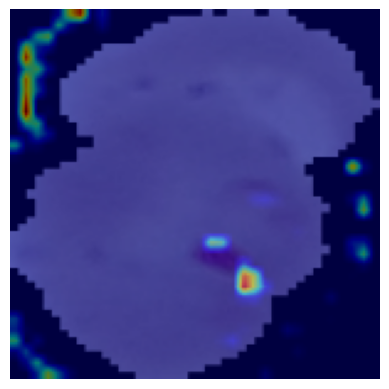

In [46]:
plt.imshow(blended_image)
plt.axis('off')
plt.show()